# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

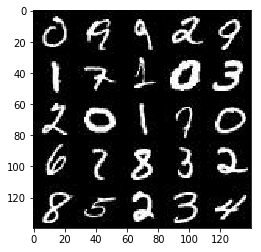

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

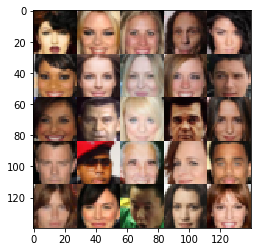

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
#        print(images.shape)
#        print(x1.shape)
#        print(x2.shape)
#        print(x3.shape)
#        print(logits.shape)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        strt = 7
        st_filt = 512 
        # First fully connected layer
        x1 = tf.layers.dense(z, strt*strt*st_filt)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, strt, strt, st_filt))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)


        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))

#        print(x1.shape)
#        print(x2.shape)
#        print(x3.shape)
#        print(logits.shape)        
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    d_out_real,d_logits_real = discriminator(input_real, False)
    g_model = generator(input_z, out_channel_dim)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    
    # Calculate losses
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
#    tf.reset_default_graph()
    
    b,x,y,c=data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, c)
    
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                ii = ii+1

                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if ii % 10 == 0 : 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)

            
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 2.4848
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.9243
Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 1.9872
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 1.4964
Epoch 1/2... Discriminator Loss: 1.5268... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 1.0221
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 1.4030
Epoch 1/2... Discriminator Loss: 1.6733... Generator Loss: 0.3839
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.6096
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.8555


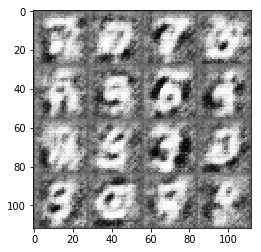

Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 1.2378
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 2.0482
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 0.9158


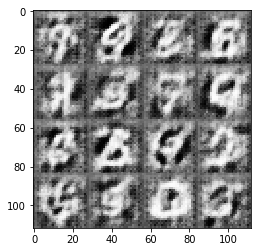

Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 2.2761
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 1.8274
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 2.1605
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 0.8568
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 1.6581
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 0.4991
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.4715


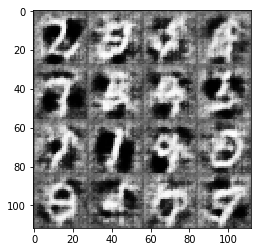

Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 1.4147
Epoch 1/2... Discriminator Loss: 1.6007... Generator Loss: 0.4083
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.5645


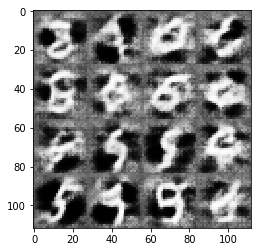

Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 1.5139
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 1.0070
Epoch 1/2... Discriminator Loss: 1.7295... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 1.4367
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.2260
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.4244


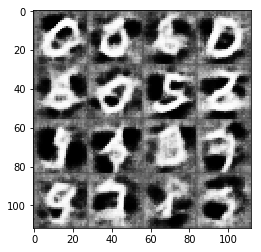

Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 1.4744... Generator Loss: 2.2783
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.0744
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 1.8040
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.9739
Epoch 1/2... Discriminator Loss: 1.8932... Generator Loss: 0.2877
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.7625


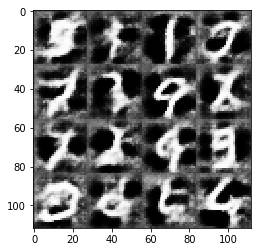

Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.1711
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.6105
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 1.3997
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.3109
Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.8890


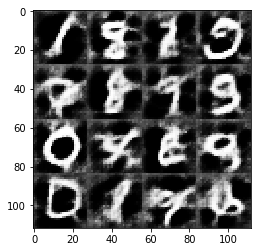

Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 1.6128
Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 1.2987
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 1.7539
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 1.1676
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5453


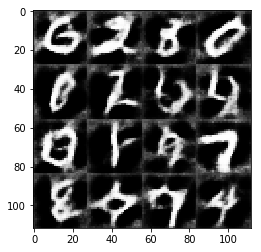

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.0714
Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.4191
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 1.2959
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.9775
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.8522


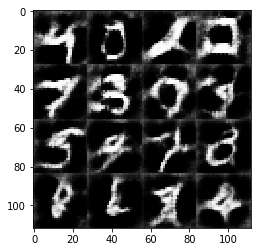

Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 1.2492
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 1.5045
Epoch 2/2... Discriminator Loss: 1.1524... Generator Loss: 1.6313
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.6992
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.5340
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.9050
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 1.9900
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 0.9365


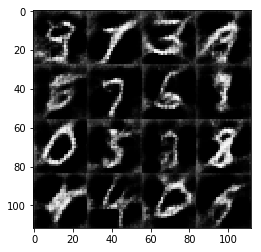

Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 1.4438
Epoch 2/2... Discriminator Loss: 1.6568... Generator Loss: 0.4458
Epoch 2/2... Discriminator Loss: 1.6410... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.5030... Generator Loss: 0.4627
Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.8086


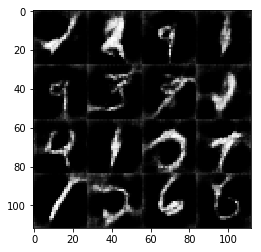

Epoch 2/2... Discriminator Loss: 1.9441... Generator Loss: 3.2529
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.5619
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.8181... Generator Loss: 0.4132
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 1.1298


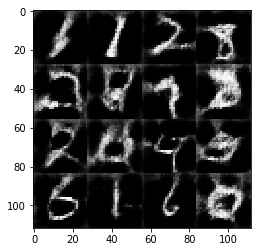

Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.4539
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.9440
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 1.3020
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 0.9597
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 0.8606... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.3029


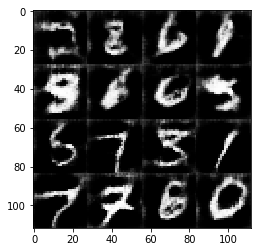

Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 1.2308
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 2.0226
Epoch 2/2... Discriminator Loss: 3.8398... Generator Loss: 4.9258
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.0565
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.1337


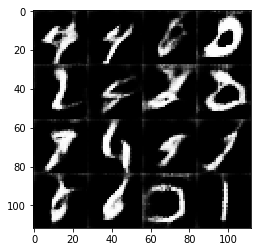

Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 1.5198
Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 1.4555
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 1.1962
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 2.2025
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.9976
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 1.2391
Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.2644


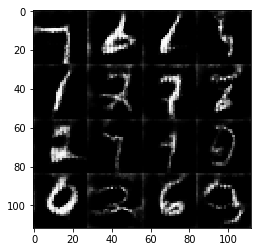

Epoch 2/2... Discriminator Loss: 1.8436... Generator Loss: 0.3526
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.7934
Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 1.5195
Epoch 2/2... Discriminator Loss: 1.4601... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.3169
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 2.1928
Epoch 2/2... Discriminator Loss: 1.4527... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.3513


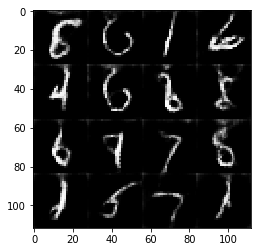

Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 0.9479
Epoch 2/2... Discriminator Loss: 1.5444... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 1.2486
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 1.5237
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.8763... Generator Loss: 0.4011
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.9064


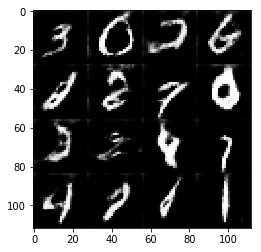

Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.3294
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 2.7204
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 1.5583
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.5453
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.5706
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 2.0059


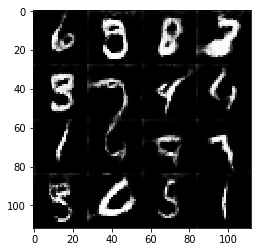

Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.6119
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 1.6179
Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.9594


In [25]:
import pickle as pkl

batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/4... Discriminator Loss: 0.9659... Generator Loss: 1.2322
Epoch 1/4... Discriminator Loss: 1.4219... Generator Loss: 5.3631
Epoch 1/4... Discriminator Loss: 1.3717... Generator Loss: 0.7478
Epoch 1/4... Discriminator Loss: 0.5960... Generator Loss: 2.8766
Epoch 1/4... Discriminator Loss: 0.5971... Generator Loss: 2.3159
Epoch 1/4... Discriminator Loss: 0.7076... Generator Loss: 1.4824
Epoch 1/4... Discriminator Loss: 0.6055... Generator Loss: 2.0920
Epoch 1/4... Discriminator Loss: 0.6151... Generator Loss: 2.1654
Epoch 1/4... Discriminator Loss: 1.6719... Generator Loss: 0.3931
Epoch 1/4... Discriminator Loss: 0.8220... Generator Loss: 5.3103


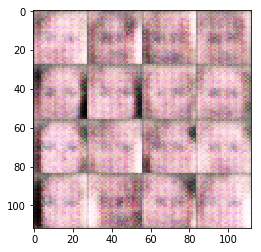

Epoch 1/4... Discriminator Loss: 2.1089... Generator Loss: 0.2727
Epoch 1/4... Discriminator Loss: 1.0892... Generator Loss: 0.8736
Epoch 1/4... Discriminator Loss: 1.6216... Generator Loss: 8.0003
Epoch 1/4... Discriminator Loss: 0.7031... Generator Loss: 1.7967
Epoch 1/4... Discriminator Loss: 1.0630... Generator Loss: 1.2413
Epoch 1/4... Discriminator Loss: 2.1910... Generator Loss: 0.2199
Epoch 1/4... Discriminator Loss: 0.8641... Generator Loss: 1.5970
Epoch 1/4... Discriminator Loss: 1.4214... Generator Loss: 0.5834
Epoch 1/4... Discriminator Loss: 1.1935... Generator Loss: 2.8888
Epoch 1/4... Discriminator Loss: 0.8065... Generator Loss: 1.1648


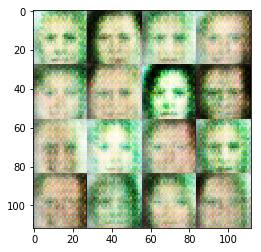

Epoch 1/4... Discriminator Loss: 1.2154... Generator Loss: 0.7562
Epoch 1/4... Discriminator Loss: 0.8843... Generator Loss: 7.9802
Epoch 1/4... Discriminator Loss: 2.0387... Generator Loss: 0.2577
Epoch 1/4... Discriminator Loss: 1.3444... Generator Loss: 0.6008
Epoch 1/4... Discriminator Loss: 1.0385... Generator Loss: 0.8308
Epoch 1/4... Discriminator Loss: 1.1794... Generator Loss: 3.3641
Epoch 1/4... Discriminator Loss: 1.5628... Generator Loss: 0.4636
Epoch 1/4... Discriminator Loss: 1.7362... Generator Loss: 0.3824
Epoch 1/4... Discriminator Loss: 0.6657... Generator Loss: 1.8375
Epoch 1/4... Discriminator Loss: 0.7407... Generator Loss: 1.9553


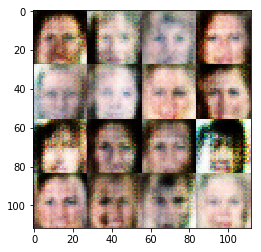

Epoch 1/4... Discriminator Loss: 0.6508... Generator Loss: 1.5714
Epoch 1/4... Discriminator Loss: 1.0622... Generator Loss: 0.7930
Epoch 1/4... Discriminator Loss: 0.3746... Generator Loss: 3.7721
Epoch 1/4... Discriminator Loss: 1.1761... Generator Loss: 1.4007
Epoch 1/4... Discriminator Loss: 0.5615... Generator Loss: 2.3716
Epoch 1/4... Discriminator Loss: 1.5098... Generator Loss: 1.8573
Epoch 1/4... Discriminator Loss: 0.8330... Generator Loss: 1.8718
Epoch 1/4... Discriminator Loss: 0.7385... Generator Loss: 3.2899
Epoch 1/4... Discriminator Loss: 0.8319... Generator Loss: 1.1160
Epoch 1/4... Discriminator Loss: 1.1530... Generator Loss: 3.1682


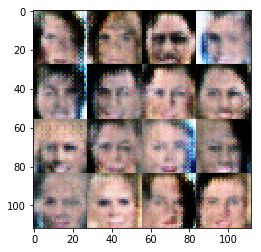

Epoch 1/4... Discriminator Loss: 0.9489... Generator Loss: 1.4571
Epoch 1/4... Discriminator Loss: 1.2456... Generator Loss: 3.5793
Epoch 1/4... Discriminator Loss: 0.6765... Generator Loss: 1.5114
Epoch 1/4... Discriminator Loss: 1.3043... Generator Loss: 0.7136
Epoch 1/4... Discriminator Loss: 3.0411... Generator Loss: 3.8751
Epoch 1/4... Discriminator Loss: 0.7377... Generator Loss: 1.6708
Epoch 1/4... Discriminator Loss: 0.9072... Generator Loss: 2.0542
Epoch 1/4... Discriminator Loss: 1.2976... Generator Loss: 0.5967
Epoch 1/4... Discriminator Loss: 1.0783... Generator Loss: 2.8808
Epoch 1/4... Discriminator Loss: 0.5430... Generator Loss: 3.3129


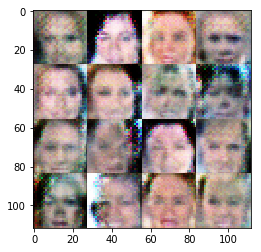

Epoch 1/4... Discriminator Loss: 0.9656... Generator Loss: 1.1575
Epoch 1/4... Discriminator Loss: 1.0888... Generator Loss: 0.7883
Epoch 1/4... Discriminator Loss: 0.9258... Generator Loss: 1.4243
Epoch 1/4... Discriminator Loss: 1.1821... Generator Loss: 1.8320
Epoch 1/4... Discriminator Loss: 1.3736... Generator Loss: 1.6520
Epoch 1/4... Discriminator Loss: 0.7055... Generator Loss: 1.3541
Epoch 1/4... Discriminator Loss: 0.7248... Generator Loss: 1.4838
Epoch 1/4... Discriminator Loss: 0.8797... Generator Loss: 1.2666
Epoch 1/4... Discriminator Loss: 1.1046... Generator Loss: 2.6524
Epoch 1/4... Discriminator Loss: 0.6970... Generator Loss: 3.0185


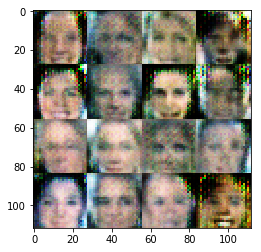

Epoch 1/4... Discriminator Loss: 1.3141... Generator Loss: 0.7102
Epoch 1/4... Discriminator Loss: 1.1465... Generator Loss: 1.0619
Epoch 1/4... Discriminator Loss: 1.3544... Generator Loss: 1.7993
Epoch 1/4... Discriminator Loss: 1.2448... Generator Loss: 2.6932
Epoch 1/4... Discriminator Loss: 0.7489... Generator Loss: 2.1816
Epoch 1/4... Discriminator Loss: 1.1141... Generator Loss: 0.7847
Epoch 1/4... Discriminator Loss: 1.1456... Generator Loss: 1.0906
Epoch 1/4... Discriminator Loss: 1.1049... Generator Loss: 0.7670
Epoch 1/4... Discriminator Loss: 1.0265... Generator Loss: 1.0128
Epoch 1/4... Discriminator Loss: 1.2801... Generator Loss: 0.5686


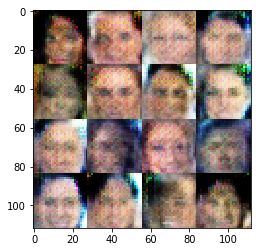

Epoch 1/4... Discriminator Loss: 1.6934... Generator Loss: 0.6568
Epoch 1/4... Discriminator Loss: 1.0567... Generator Loss: 1.1769
Epoch 1/4... Discriminator Loss: 0.9087... Generator Loss: 2.6801
Epoch 1/4... Discriminator Loss: 1.0515... Generator Loss: 2.6064
Epoch 1/4... Discriminator Loss: 0.8779... Generator Loss: 0.9912
Epoch 1/4... Discriminator Loss: 0.9744... Generator Loss: 0.8805
Epoch 1/4... Discriminator Loss: 1.5650... Generator Loss: 1.6888
Epoch 1/4... Discriminator Loss: 1.2308... Generator Loss: 0.8261
Epoch 1/4... Discriminator Loss: 1.2337... Generator Loss: 0.7634
Epoch 1/4... Discriminator Loss: 1.5634... Generator Loss: 1.7011


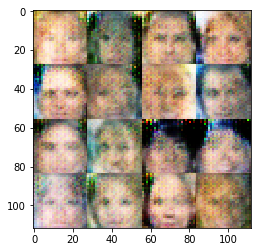

Epoch 1/4... Discriminator Loss: 1.3142... Generator Loss: 3.2897
Epoch 1/4... Discriminator Loss: 0.7354... Generator Loss: 1.6947
Epoch 1/4... Discriminator Loss: 1.7116... Generator Loss: 0.3299
Epoch 1/4... Discriminator Loss: 1.1219... Generator Loss: 1.1533
Epoch 1/4... Discriminator Loss: 0.8759... Generator Loss: 3.2072
Epoch 1/4... Discriminator Loss: 1.4842... Generator Loss: 1.7239
Epoch 1/4... Discriminator Loss: 1.0430... Generator Loss: 1.0678
Epoch 1/4... Discriminator Loss: 1.2467... Generator Loss: 0.7348
Epoch 1/4... Discriminator Loss: 0.9478... Generator Loss: 1.4176
Epoch 1/4... Discriminator Loss: 1.0751... Generator Loss: 1.3671


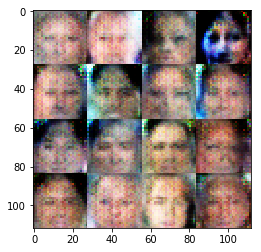

Epoch 1/4... Discriminator Loss: 2.4289... Generator Loss: 4.2597
Epoch 1/4... Discriminator Loss: 0.7075... Generator Loss: 1.5229
Epoch 1/4... Discriminator Loss: 1.2139... Generator Loss: 1.5283
Epoch 1/4... Discriminator Loss: 1.4388... Generator Loss: 0.9418
Epoch 1/4... Discriminator Loss: 1.4189... Generator Loss: 0.6581
Epoch 1/4... Discriminator Loss: 1.4683... Generator Loss: 0.7162
Epoch 1/4... Discriminator Loss: 1.2782... Generator Loss: 0.7680
Epoch 1/4... Discriminator Loss: 0.9261... Generator Loss: 2.9490
Epoch 1/4... Discriminator Loss: 1.4660... Generator Loss: 0.5271
Epoch 1/4... Discriminator Loss: 0.7217... Generator Loss: 1.5814


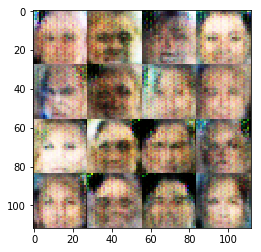

Epoch 1/4... Discriminator Loss: 0.6473... Generator Loss: 1.7865
Epoch 1/4... Discriminator Loss: 1.3922... Generator Loss: 0.5704
Epoch 1/4... Discriminator Loss: 1.3055... Generator Loss: 1.0796
Epoch 1/4... Discriminator Loss: 1.2229... Generator Loss: 1.2294
Epoch 1/4... Discriminator Loss: 1.3406... Generator Loss: 0.9337
Epoch 1/4... Discriminator Loss: 1.2985... Generator Loss: 0.7108
Epoch 1/4... Discriminator Loss: 1.2061... Generator Loss: 0.9575
Epoch 1/4... Discriminator Loss: 1.1771... Generator Loss: 1.0128
Epoch 1/4... Discriminator Loss: 1.3257... Generator Loss: 0.5977
Epoch 1/4... Discriminator Loss: 1.4782... Generator Loss: 0.4511


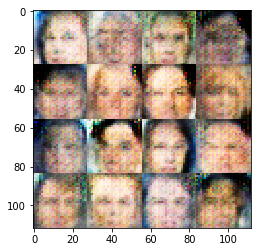

Epoch 1/4... Discriminator Loss: 1.4140... Generator Loss: 3.1184
Epoch 1/4... Discriminator Loss: 1.1666... Generator Loss: 0.7258
Epoch 1/4... Discriminator Loss: 0.7689... Generator Loss: 1.5809
Epoch 1/4... Discriminator Loss: 1.0561... Generator Loss: 2.2644
Epoch 1/4... Discriminator Loss: 0.7512... Generator Loss: 1.2213
Epoch 1/4... Discriminator Loss: 1.5240... Generator Loss: 0.4239
Epoch 1/4... Discriminator Loss: 1.2540... Generator Loss: 0.7221
Epoch 1/4... Discriminator Loss: 1.0201... Generator Loss: 1.8960
Epoch 1/4... Discriminator Loss: 0.9274... Generator Loss: 1.0076
Epoch 1/4... Discriminator Loss: 1.9913... Generator Loss: 3.5473


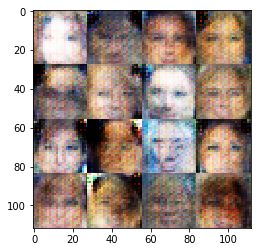

Epoch 1/4... Discriminator Loss: 1.0646... Generator Loss: 0.8681
Epoch 1/4... Discriminator Loss: 1.1630... Generator Loss: 1.1852
Epoch 1/4... Discriminator Loss: 1.1826... Generator Loss: 0.6766
Epoch 1/4... Discriminator Loss: 1.2204... Generator Loss: 0.6236
Epoch 1/4... Discriminator Loss: 1.4587... Generator Loss: 0.9213
Epoch 1/4... Discriminator Loss: 1.4181... Generator Loss: 0.6319
Epoch 1/4... Discriminator Loss: 1.4033... Generator Loss: 0.9277
Epoch 1/4... Discriminator Loss: 0.9580... Generator Loss: 1.1485
Epoch 1/4... Discriminator Loss: 1.0227... Generator Loss: 1.0956
Epoch 1/4... Discriminator Loss: 1.2199... Generator Loss: 0.8573


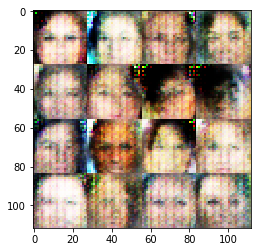

Epoch 1/4... Discriminator Loss: 1.3318... Generator Loss: 1.1901
Epoch 1/4... Discriminator Loss: 1.2989... Generator Loss: 0.8438
Epoch 1/4... Discriminator Loss: 1.4605... Generator Loss: 0.6927
Epoch 1/4... Discriminator Loss: 1.1932... Generator Loss: 0.8814
Epoch 1/4... Discriminator Loss: 1.2586... Generator Loss: 0.5833
Epoch 1/4... Discriminator Loss: 1.2732... Generator Loss: 1.5680
Epoch 1/4... Discriminator Loss: 1.0112... Generator Loss: 1.4363
Epoch 1/4... Discriminator Loss: 1.1529... Generator Loss: 1.1603
Epoch 1/4... Discriminator Loss: 0.7118... Generator Loss: 1.6394
Epoch 1/4... Discriminator Loss: 1.1447... Generator Loss: 0.9028


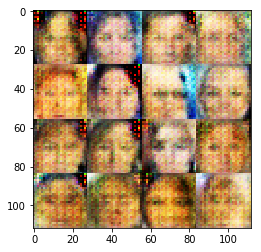

Epoch 1/4... Discriminator Loss: 1.1338... Generator Loss: 1.0877
Epoch 1/4... Discriminator Loss: 1.0768... Generator Loss: 1.8883
Epoch 1/4... Discriminator Loss: 1.2033... Generator Loss: 0.9571
Epoch 1/4... Discriminator Loss: 1.4326... Generator Loss: 0.4776
Epoch 1/4... Discriminator Loss: 0.4607... Generator Loss: 3.4175
Epoch 1/4... Discriminator Loss: 1.1634... Generator Loss: 0.6616
Epoch 1/4... Discriminator Loss: 1.2926... Generator Loss: 0.5318
Epoch 1/4... Discriminator Loss: 1.0706... Generator Loss: 1.2595
Epoch 1/4... Discriminator Loss: 1.5458... Generator Loss: 4.0615
Epoch 1/4... Discriminator Loss: 1.8283... Generator Loss: 1.4628


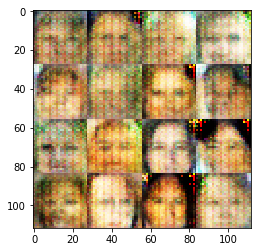

Epoch 1/4... Discriminator Loss: 1.2498... Generator Loss: 1.0452
Epoch 1/4... Discriminator Loss: 1.2009... Generator Loss: 0.7734
Epoch 1/4... Discriminator Loss: 1.1584... Generator Loss: 1.0661
Epoch 1/4... Discriminator Loss: 1.1414... Generator Loss: 3.5596
Epoch 1/4... Discriminator Loss: 0.9935... Generator Loss: 3.7682
Epoch 1/4... Discriminator Loss: 0.9194... Generator Loss: 0.9212
Epoch 1/4... Discriminator Loss: 1.0304... Generator Loss: 0.8558
Epoch 1/4... Discriminator Loss: 0.7645... Generator Loss: 1.5524
Epoch 1/4... Discriminator Loss: 1.1449... Generator Loss: 0.7633
Epoch 1/4... Discriminator Loss: 0.6038... Generator Loss: 2.2869


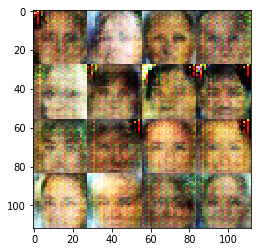

Epoch 1/4... Discriminator Loss: 1.2761... Generator Loss: 0.6037
Epoch 1/4... Discriminator Loss: 1.1018... Generator Loss: 0.9557
Epoch 1/4... Discriminator Loss: 0.9322... Generator Loss: 1.0136
Epoch 1/4... Discriminator Loss: 1.0399... Generator Loss: 0.8769
Epoch 1/4... Discriminator Loss: 1.2875... Generator Loss: 0.6124
Epoch 1/4... Discriminator Loss: 1.0913... Generator Loss: 0.7865
Epoch 1/4... Discriminator Loss: 0.7585... Generator Loss: 1.2278
Epoch 1/4... Discriminator Loss: 1.4516... Generator Loss: 2.8621
Epoch 1/4... Discriminator Loss: 0.9748... Generator Loss: 1.0011
Epoch 1/4... Discriminator Loss: 1.0269... Generator Loss: 0.8999


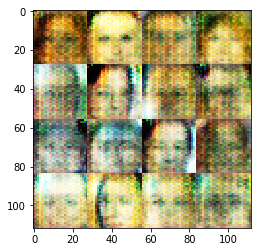

Epoch 1/4... Discriminator Loss: 0.8775... Generator Loss: 1.5016
Epoch 1/4... Discriminator Loss: 1.0890... Generator Loss: 1.7295
Epoch 1/4... Discriminator Loss: 0.5619... Generator Loss: 2.2736
Epoch 1/4... Discriminator Loss: 0.9937... Generator Loss: 2.2301
Epoch 1/4... Discriminator Loss: 1.4550... Generator Loss: 0.5639
Epoch 1/4... Discriminator Loss: 0.9198... Generator Loss: 1.3930
Epoch 1/4... Discriminator Loss: 1.1686... Generator Loss: 2.1597
Epoch 1/4... Discriminator Loss: 0.7575... Generator Loss: 1.3767
Epoch 1/4... Discriminator Loss: 1.3298... Generator Loss: 0.5264
Epoch 1/4... Discriminator Loss: 1.1634... Generator Loss: 0.8185


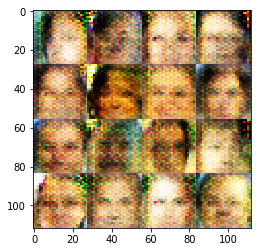

Epoch 1/4... Discriminator Loss: 0.8856... Generator Loss: 1.0552
Epoch 1/4... Discriminator Loss: 0.6119... Generator Loss: 2.6141
Epoch 1/4... Discriminator Loss: 1.1516... Generator Loss: 0.7178
Epoch 1/4... Discriminator Loss: 1.0333... Generator Loss: 0.7824
Epoch 1/4... Discriminator Loss: 0.8338... Generator Loss: 1.2591
Epoch 1/4... Discriminator Loss: 0.9507... Generator Loss: 1.2479
Epoch 1/4... Discriminator Loss: 1.0396... Generator Loss: 0.7864
Epoch 1/4... Discriminator Loss: 0.5457... Generator Loss: 2.0171
Epoch 1/4... Discriminator Loss: 1.4466... Generator Loss: 0.5376
Epoch 1/4... Discriminator Loss: 0.9543... Generator Loss: 2.1863


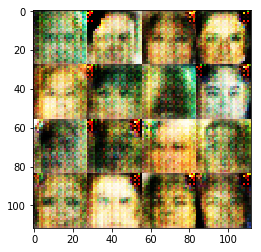

Epoch 1/4... Discriminator Loss: 0.8173... Generator Loss: 2.9668
Epoch 1/4... Discriminator Loss: 1.1419... Generator Loss: 0.7251
Epoch 1/4... Discriminator Loss: 1.2168... Generator Loss: 0.8808
Epoch 1/4... Discriminator Loss: 0.7485... Generator Loss: 2.0686
Epoch 1/4... Discriminator Loss: 1.0395... Generator Loss: 0.8084
Epoch 1/4... Discriminator Loss: 0.6762... Generator Loss: 1.7897
Epoch 1/4... Discriminator Loss: 0.8266... Generator Loss: 2.0374
Epoch 1/4... Discriminator Loss: 1.0431... Generator Loss: 1.4389


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.